In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from PIL import Image
import os
import pandas as pd
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
from tqdm import tqdm
from torchinfo import summary as tsummary
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cpu


# Prep DATASET

In [3]:
class SeqDataset(Dataset):
    def __init__(self, csv_path, seq_root, seq_len=30, transform=None):
        self.df = pd.read_csv(csv_path)
        self.seq_root = seq_root
        self.seq_len = seq_len
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        seq_name = row["sequence"] 
        label = row["label"]

        seq_folder = os.path.join(self.seq_root, seq_name)

        frames = []
        for i in range(1, self.seq_len + 1):
            img_path = os.path.join(seq_folder, f"{i:05d}.jpg")

            img = Image.open(img_path).convert("RGB")

            if self.transform:
                img = self.transform(img)

            frames.append(img)

        frames = torch.stack(frames)

        return frames, torch.tensor(label, dtype=torch.float32)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ## imgnet stats
])


train_dataset = SeqDataset(
    csv_path = "Data/train/train.csv",
    seq_root = "Data/train/sequences",
    seq_len=30,
    transform=transform
)
val_dataset = SeqDataset(
    csv_path = "Data/validation/validation.csv",
    seq_root = "Data/validation/sequences",
    seq_len=30,
    transform=transform
)

test_dataset = SeqDataset(
    csv_path = "Data/test/test.csv",
    seq_root = "Data/test/sequences",
    seq_len=30,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 618
Number of validation samples: 256
Number of test samples: 116


# DEFINE MODEL

### ResNet + LSTM + FC

In [5]:
class RES_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, dropout= 0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        RES = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for p in RES.parameters():
            p.requires_grad = False

        modules = list(RES.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)

        feat = self.cnn(x)
        feat = feat.view(B, T, 512)

        out, _ = self.lstm(feat)
        last = out[:, -1, :]

        logit = self.fc(last)
        return logit

    

# Define func Train / Evaludate

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for (x, y) in tqdm(loader, desc="Training", leave=True):
        x = x.to(device)
        y = y.to(device).float() # label is int so convert to float

        optimizer.zero_grad()
        logits = model(x).squeeze(1)

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size

        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        total += batch_size

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for (x, y) in tqdm(loader, desc="Evaluating", leave=True):
        x = x.to(device)
        y = y.to(device).float()

        logits = model(x).squeeze(1)

        loss = criterion(logits, y)

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size

        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        total += batch_size

    return total_loss / total, correct / total

In [7]:
model = RES_LSTM(hidden_size=256, num_layers=2, dropout=0.3)
model = model.to(device)

tsummary(model, input_size=(1, 30, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
RES_LSTM                                      [1, 1]                    --
├─Sequential: 1-1                             [30, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [30, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [30, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [30, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [30, 64, 56, 56]          --
│    └─Sequential: 2-5                        [30, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [30, 64, 56, 56]          (73,984)
│    │    └─BasicBlock: 3-2                   [30, 64, 56, 56]          (73,984)
│    └─Sequential: 2-6                        [30, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [30, 128, 28, 28]         (230,144)
│    │    └─BasicBlock: 3-4                   [30, 128, 28, 28]     

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 20

best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.3f}, Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.3f}, Acc: {val_acc*100:.2f}%" )
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss: # Early Stopping
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("improved")
    else:
        patience_counter += 1
        print("not improved")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Training:   0%|          | 0/78 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 32/32 [02:41<00:00,  5.05s/it]


Epoch 00 | Train Loss: 0.611, Acc: 66.50% | Val Loss: 0.544, Acc: 73.05%
improved


Evaluating: 100%|██████████| 32/32 [02:43<00:00,  5.09s/it]


Epoch 01 | Train Loss: 0.496, Acc: 77.18% | Val Loss: 0.515, Acc: 73.05%
improved


Evaluating: 100%|██████████| 32/32 [02:36<00:00,  4.90s/it]


Epoch 02 | Train Loss: 0.428, Acc: 80.10% | Val Loss: 0.472, Acc: 77.34%
improved


Evaluating: 100%|██████████| 32/32 [02:35<00:00,  4.87s/it]


Epoch 03 | Train Loss: 0.413, Acc: 80.42% | Val Loss: 0.448, Acc: 80.08%
improved


Evaluating: 100%|██████████| 32/32 [02:35<00:00,  4.85s/it]


Epoch 04 | Train Loss: 0.417, Acc: 79.29% | Val Loss: 0.465, Acc: 76.56%
not improved


Evaluating: 100%|██████████| 32/32 [02:38<00:00,  4.94s/it]


Epoch 05 | Train Loss: 0.409, Acc: 78.96% | Val Loss: 0.439, Acc: 80.08%
improved


Evaluating: 100%|██████████| 32/32 [02:36<00:00,  4.88s/it]


Epoch 06 | Train Loss: 0.382, Acc: 81.23% | Val Loss: 0.611, Acc: 64.06%
not improved


Evaluating: 100%|██████████| 32/32 [02:28<00:00,  4.65s/it]


Epoch 07 | Train Loss: 0.396, Acc: 81.39% | Val Loss: 0.464, Acc: 78.52%
not improved


Evaluating: 100%|██████████| 32/32 [02:33<00:00,  4.79s/it]


Epoch 08 | Train Loss: 0.363, Acc: 82.36% | Val Loss: 0.396, Acc: 81.25%
improved


Evaluating: 100%|██████████| 32/32 [02:33<00:00,  4.78s/it]


Epoch 09 | Train Loss: 0.376, Acc: 82.52% | Val Loss: 0.416, Acc: 80.47%
not improved


Evaluating: 100%|██████████| 32/32 [02:32<00:00,  4.77s/it]


Epoch 10 | Train Loss: 0.343, Acc: 84.79% | Val Loss: 0.412, Acc: 79.69%
not improved


Evaluating: 100%|██████████| 32/32 [02:25<00:00,  4.54s/it]


Epoch 11 | Train Loss: 0.360, Acc: 85.11% | Val Loss: 0.426, Acc: 77.73%
not improved


Evaluating: 100%|██████████| 32/32 [02:23<00:00,  4.49s/it]


Epoch 12 | Train Loss: 0.348, Acc: 83.33% | Val Loss: 0.432, Acc: 80.86%
not improved


Evaluating: 100%|██████████| 32/32 [02:24<00:00,  4.53s/it]


Epoch 13 | Train Loss: 0.331, Acc: 83.82% | Val Loss: 0.428, Acc: 78.52%
not improved
Early stopping triggered!


Evaluating: 100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


Test Loss: 0.3515, Test Acc: 0.8534


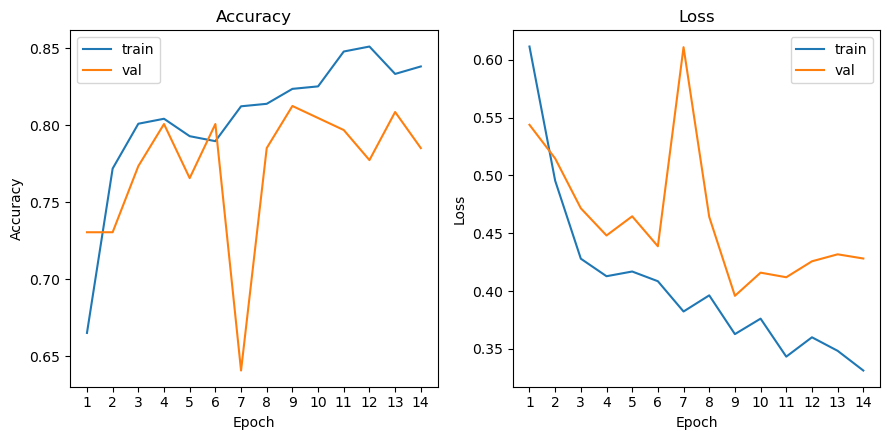

In [10]:

epochs_ax = range(1, EPOCHS + 1)
len = len(train_losses)
epochs_ax = epochs_ax[:len]

plt.figure(figsize=(9, 4.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_ax, train_accuracies, label='train')
plt.plot(epochs_ax, val_accuracies, label='val')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.xticks(list(epochs_ax))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_ax, train_losses, label='train')
plt.plot(epochs_ax, val_losses, label='val')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.xticks(list(epochs_ax))
plt.legend()
plt.tight_layout()
plt.show()
